<a href="https://colab.research.google.com/github/santhoshmohan8/MachineLearning/blob/main/Logistic_Spam_Mail_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Objective :

Build a classification model using logistic regression algorithm. Initially a baseline model is build, and Basic logistic regression model is built and a hyperparameter tuned logistic model is build.
Different evaluation metrics like confusion matrix, accuracy, precision are chosen to evaluate the performance of the model.
AUC-ROC and AUC-PR plots are compared to see any significant performance insight across plots.

Spam mail prediction dataset is choosen for this exercise.

In [9]:
import pandas as pd
import numpy as np

spam_data = pd.read_csv("mail_data.csv")
spam_data.head()

spam_data.isna().sum()
print(spam_data.shape,"\n\n\n")
spam_data.info()
print(spam_data.describe(),"\n\n")
spam_data = spam_data.where((pd.notnull(spam_data)),'') # replace NaN values if any
print("Event rate for target : \n",spam_data.Category.value_counts()/spam_data.shape[0]*100)

(5572, 2) 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
       Category                 Message
count      5572                    5572
unique        2                    5157
top         ham  Sorry, I'll call later
freq       4825                      30 


Event rate for target : 
 Category
ham     86.593683
spam    13.406317
Name: count, dtype: float64


Target variable is categorical, so converting them using Label Encoder

*inverse_transform - Checking what is the encoded value for each categories*

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(spam_data['Category'])

spam_data = pd.concat([spam_data,pd.Series(target_encoded)], axis=1).drop(columns=['Category']).rename(columns={0:'Category'})
spam_data.head()

target_decoded = encoder.inverse_transform(target_encoded)
print(pd.DataFrame(np.vstack((target_decoded,target_encoded)).T).groupby([0,1]).nunique())

Empty DataFrame
Columns: []
Index: [(ham, 0), (spam, 1)]


Train test split & TFIDF vectorizer for text features

In [11]:
from sklearn.model_selection import train_test_split
x = spam_data['Message']
y = spam_data['Category']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=3)

from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer(stop_words='english',min_df = 1,lowercase = True)

x_train_feature = vector.fit_transform(x_train)
x_train_feature.shape
x_test_feature = vector.transform(x_test)
x_test_feature.shape

y_train = y_train.astype('int')
y_test = y_test.astype('int')

Model performance metrics - Function

In [22]:
from sklearn import metrics
def model_performance(y_test,y_test_predict):
  cm=metrics.confusion_matrix(y_test,y_test_predict)
  precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_test_predict)
  print("\n\nConfusion matrix :\n",cm)
  print("\n\nClassification report :\n",metrics.classification_report(y_test,y_test_predict))
  print("\nAccuracy score :",metrics.accuracy_score(y_test,y_test_predict))
  print("\nAUC-ROC Value :",metrics.roc_auc_score(y_test,y_test_predict))
  print("\nAUC-PR Value",metrics.auc(recall, precision))

Baseline Predictions

In [23]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier(strategy='uniform').fit(x_train_feature,y_train)
y_train_predict = model.predict(x_train_feature)
y_test_predict = model.predict(x_test_feature)
model_performance(y_test,y_test_predict)



Confusion matrix :
 [[506 454]
 [ 76  79]]


Classification report :
               precision    recall  f1-score   support

           0       0.87      0.53      0.66       960
           1       0.15      0.51      0.23       155

    accuracy                           0.52      1115
   macro avg       0.51      0.52      0.44      1115
weighted avg       0.77      0.52      0.60      1115


Accuracy score : 0.5246636771300448

AUC-ROC Value : 0.5183803763440861

AUC-PR Value 0.36302824517746557


Logistic model with Hyperparameter tuning

In [24]:
from sklearn.linear_model import LogisticRegression
model_list = [
    LogisticRegression(),
    LogisticRegression(C=1, solver='newton-cg', penalty='l2', max_iter=100),
    LogisticRegression(C=1, solver='lbfgs', penalty='l2', max_iter=100),
    LogisticRegression(C=1, solver='sag', penalty='l2', max_iter=100),
    LogisticRegression(C=1, solver='saga', penalty='l2', max_iter=100)
]

for model in model_list:
  model.fit(x_train_feature,y_train)
  y_train_predict = model.predict(x_train_feature)
  y_test_predict = model.predict(x_test_feature)
  model_performance(y_test,y_test_predict)



Confusion matrix :
 [[960   0]
 [ 38 117]]


Classification report :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       960
           1       1.00      0.75      0.86       155

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115


Accuracy score : 0.9659192825112107

AUC-ROC Value : 0.8774193548387097

AUC-PR Value 0.8944597135831043


Confusion matrix :
 [[960   0]
 [ 38 117]]


Classification report :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       960
           1       1.00      0.75      0.86       155

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115


Accuracy score : 0.9659192825112107

AUC-ROC Value : 0.8774193548387097

AUC-PR Value 0.8944597

Parameter tuning with Grid Search CV

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

from sklearn.model_selection import GridSearchCV
model_cv = {'C':[0.1,1,10],
              'solver':['newton-cg','lbfgs','sag','saga'],
              'penalty':['l2'],
              'max_iter':[100]}

model_GSCV = GridSearchCV(estimator=model,param_grid = model_cv,cv=3).fit(x_train_feature,y_train)
print(model_GSCV.best_params_)
print(model_GSCV.best_score_)

/Users/priya/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/priya/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/priya/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
0.9697105645961636


Using best parameters to build a model

In [26]:
model = LogisticRegression(**model_GSCV.best_params_).fit(x_train_feature,y_train)
y_train_predict = model.predict(x_train_feature)
y_test_predict = model.predict(x_test_feature)
model_performance(y_test,y_test_predict)



Confusion matrix :
 [[959   1]
 [ 19 136]]


Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       960
           1       0.99      0.88      0.93       155

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Accuracy score : 0.9820627802690582

AUC-ROC Value : 0.9381888440860215

AUC-PR Value 0.9435802217550558


Plot AUC-ROC curve and AUC-PR Curve

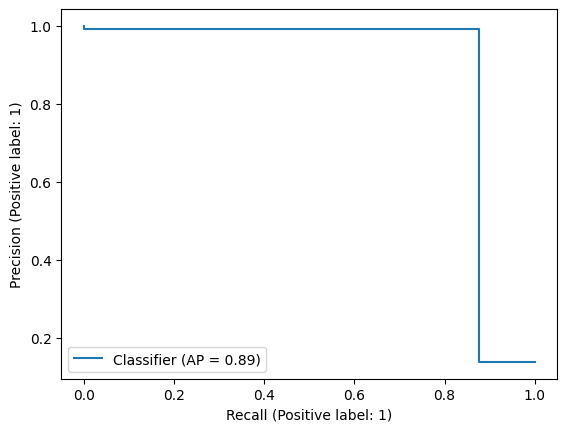

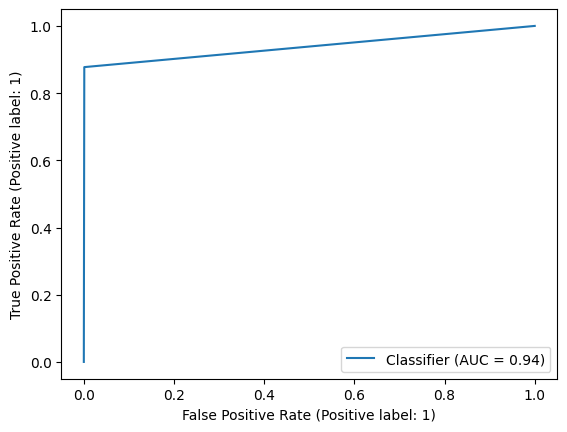

In [35]:
from sklearn import metrics
metrics.PrecisionRecallDisplay.from_predictions(y_test,y_test_predict)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_predict)